# Numerical differentiation of non-uniformly sampled data

* Different data generators
* Different algorithms to calculate the derivative and to use that measure to predict the next sample
* Asymmetrical error measure

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Data generators

Probability distribution of the initial value $r$ at time sample $k = 0$:

$$
p(r, k=0) \sim N(\mu_i, \sigma_i)
$$

Probability of observing a sample at instant $k$:

$$
p(k) \sim \text{Bernoulli}(p_s)
$$

If there is a sample at time instant $k$ the new sample is drawn from the probability distribution:

$$
p(r, k) \sim N(\mu_\delta + r_{\text{previous}}, \sigma_\delta)
$$

In [5]:
def generator1(mu_i, sigma_i, p_s, mu_delta, sigma_delta, K):
    
    # Initial value
    rs = [max(0.0, np.random.normal(mu_i, sigma_i))]
    ks = [0]
    
    for k in range(1, K):
        # Is there a sample?
        s = np.random.binomial(1, p_s)
        
        if s == 1:
            ks.append(k)
            rs.append(max(0.0, np.random.normal(mu_delta + rs[-1], sigma_delta)))
    
    return ks, rs

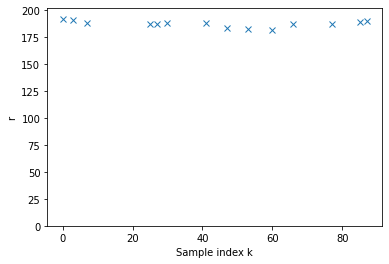

In [19]:
ks,rs = generator1(200, 10, 0.1, 1, 3, 100)

plt.plot(ks,rs,'x')
plt.ylim(0, max(rs)+10)
plt.xlabel('Sample index k')
plt.ylabel('r')
plt.show()

In [38]:
def exponential_filter(ks, rs, tau):
    
    # Preconditions
    assert len(ks) == len(rs)
    assert tau > 0
    
    # Initialise the output of the filter
    y = [None for _ in range(len(ks))]
    
    y[0] = rs[0]
    
    for k in range(1, len(ks)):
        T = ks[k] - ks[k-1]
        a = np.exp(-T/tau)
        y[k] = a * y[k-1] + (1 - a)*rs[k]
    
    return y

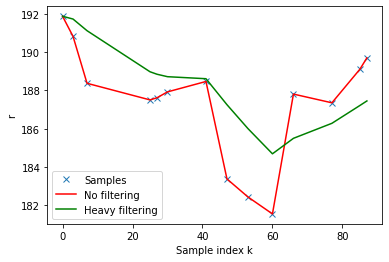

In [39]:
plt.plot(ks,rs,'x',label='Samples')
plt.plot(ks,exponential_filter(ks, rs, tau=1e-3),'r-', label='No filtering')
plt.plot(ks,exponential_filter(ks, rs, tau=20),'g-', label='Heavy filtering')
#plt.ylim(0, max(rs)+10)
plt.xlabel('Sample index k')
plt.ylabel('r')
plt.legend()
plt.show()

In [40]:
from numpy.polynomial import Polynomial

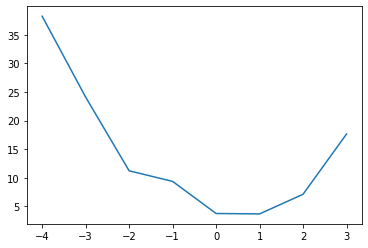

In [80]:
x = np.arange(-4, 4)
y = 2*np.power(x,2) - 1*x + 3 + np.random.normal(0, 2.4, len(x))


plt.plot(x,y)
plt.show()

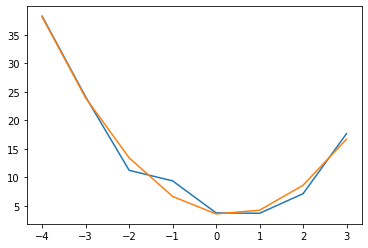

In [82]:
deg = 2
f = np.polyfit(x, y, deg)

y_pred = np.zeros(len(x))
for idx in range(0,deg+1):
    y_pred += f[idx] * np.power(x, deg-idx)

plt.plot(x, y, label='data')
plt.plot(x, y_pred, label='prediction')
plt.show()

In [83]:
def fit_polynomial(x, y, degree):
    
    f = np.polyfit(x, y, deg)
    
    y_pred = np.zeros(len(x))
    for idx in range(0,deg+1):
        y_pred += f[idx] * np.power(x, deg-idx)
    
    return y_pred[-1]

In [118]:
def window_data(x, k, width):
    
    lower_idx = max(0, k - width + 1)
    upper_idx = k + 1
    
    return x[lower_idx : upper_idx]
    
# Tests
assert window_data([0,1,2,3], 0, 1) == [0]
assert window_data([0,1,2,3], 0, 2) == [0]
assert window_data([0,1,2,3], 2, 2) == [1,2]
assert window_data([0,1,2,3], 2, 1) == [2]
assert window_data([0,1,2,3], 2, 3) == [0, 1, 2]

In [133]:
def polynomial_filter(ks, rs, degree, window_size):
    
    # Preconditions
    assert len(ks) == len(rs)
    assert degree > 0 and type(degree) == int
    assert window_size > 0 and type(window_size) == int
    assert window_size >= degree
    
    r_pred = [None for _ in range(len(ks))]
    
    for k in range(len(ks)):
        
        n_samples_available = k+1

        ks_windowed = window_data(ks, k, window_size)
        rs_windowed = window_data(rs, k, window_size)
        
        if n_samples_available < window_size:
            r_pred[k] = rs[k]
        else:
            r_pred[k] = fit_polynomial(ks_windowed, rs_windowed, degree)
            
    return r_pred

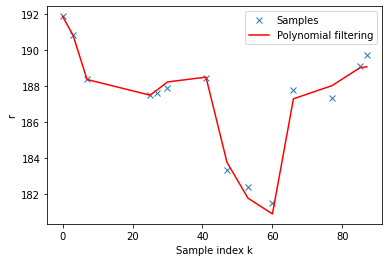

In [155]:
plt.plot(ks,rs,'x',label='Samples')
plt.plot(ks,polynomial_filter(ks, rs, degree=2, window_size=5),'r-', label='Polynomial filtering')
#plt.ylim(0, max(rs)+10)
plt.xlabel('Sample index k')
plt.ylabel('r')
plt.legend()
plt.show()

Moving Average Convergence Divergence (MACD) provides an estimate of the derivative.

In [145]:
def macd_filter(ks, rs, tau1, tau2):
    
    # Preconditions
    assert len(ks) == len(rs)
    assert tau1 > 0
    assert tau2 > 0
    assert tau1 < tau2
    
    # Initialise the output of the filter
    y1 = [None for _ in range(len(ks))]
    y2 = [None for _ in range(len(ks))]
    y = [None for _ in range(len(ks))]
    
    y1[0] = rs[0]
    y2[0] = rs[0]
    
    for k in range(1, len(ks)):
        T = ks[k] - ks[k-1]
        
        a1 = np.exp(-T/tau1)
        y1[k] = a1 * y1[k-1] + (1 - a1)*rs[k]
        
        a2 = np.exp(-T/tau2)
        y2[k] = a2 * y2[k-1] + (1 - a2)*rs[k]
    
        y[k] = y1[k] - y2[k]
    
    return y

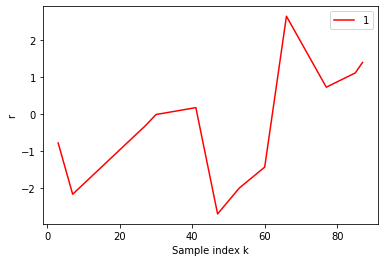

In [149]:
#plt.plot(ks,rs,'x',label='Samples')
plt.plot(ks, macd_filter(ks, rs, tau1=0.1, tau2=10), 'r-', label='1')
#plt.ylim(0, max(rs)+10)
plt.xlabel('Sample index k')
plt.ylabel('r')
plt.legend()
plt.show()